# Visão Computacional com Aprendizado Profundo

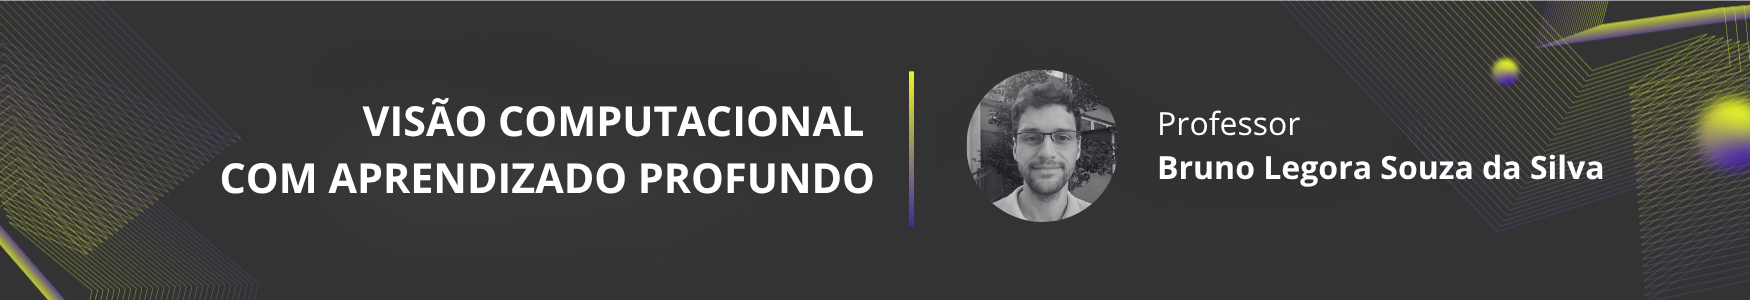

# Exercício Avaliativo nº 4

Esse exercício possui valor de 10 pontos na disciplina. Vocês irão encontrar 3 questões, façam elas nos campos de código indicados, sem remover nenhum campo de texto ou adicionar novos campos de código

In [3]:
import torch
import cv2
import numpy as np
import scipy
import torchvision
import os
#from google.colab.patches import cv2_imshow
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")


Using device: cuda


# Parte 1:

### Questão nº 01 (3 pts)

Sugira e implemente formas de melhorar o código do Laboratório 7 para melhorar a etapa de treinamento da U-net, tanto em termos de tempo de processamento quanto métrica de erro.

O resultado do código da seção abaixo deve ter perdas bem menores que as encontradas no laboratório.

Obs: Sem ser aumentar o número de iterações, trocar a arquitetura da rede ou ainda aumentar o número de épocas.






In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms.functional import pil_to_tensor
from tqdm import tqdm
import numpy as np
from torch.cuda.amp import autocast, GradScaler


working_dir = "."

pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

In [4]:
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
import torch
import torchvision

class BlocoEncoder(torch.nn.Module):

    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        self.layer1 = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=3, padding=padding)
        self.layer2 = torch.nn.ReLU(inplace=True)
        self.layer3 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.layer4 = torch.nn.ReLU(inplace=True)
        self.layer5 = torch.nn.MaxPool2d(2)

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.layer5(x)
      return x


class BlocoDecoder(torch.nn.Module):

    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        # upconv diminui o numero de canais pela metade!
        self.up = torch.nn.ConvTranspose2d(num_canais_entrada, num_canais_entrada // 2, kernel_size=2, stride=2)
        self.layer1 = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=3, padding=padding)
        self.layer2 = torch.nn.ReLU(inplace=True)
        self.layer3 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.layer4 = torch.nn.ReLU(inplace=True)

    def forward(self, x, skip_connection):
      x = self.up(x)
      skip_connection = torchvision.transforms.Resize((x.size()[2],x.size()[3]))(skip_connection)
      x = torch.cat([skip_connection, x], dim=1)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      return x

class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes, padding='valid'):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.encoder1 = BlocoEncoder(n_channels,64,padding=padding)
        self.encoder2 = BlocoEncoder(64,128,padding=padding)
        self.encoder3 = BlocoEncoder(128,256,padding=padding)
        self.encoder4 = BlocoEncoder(256,512,padding=padding)
        self.base1 = torch.nn.Conv2d(512, 1024, kernel_size=3, padding=padding)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.base2 = torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=padding)
        self.relu2 =  torch.nn.ReLU(inplace=True)
        self.decoder1 = BlocoDecoder(1024,512,padding=padding)
        self.decoder2 = BlocoDecoder(512,256,padding=padding)
        self.decoder3 = BlocoDecoder(256,128,padding=padding)
        self.decoder4 = BlocoDecoder(128,64,padding=padding)
        self.conv1 = torch.nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x = self.base1(x4)
        x = self.relu1(x)
        x = self.base2(x)
        x = self.relu2(x)
        x = self.decoder1(x,x4) # skip connection aqui!
        x = self.decoder2(x,x3) # skip connection aqui!
        x = self.decoder3(x,x2) # skip connection aqui!
        x = self.decoder4(x,x1) # skip connection aqui!
        x = self.conv1(x)
        return x

In [ ]:

unet = UNet(3,2)

pets_train_orig, pets_test_orig

(train_pets_input, train_pets_target) = pets_train_orig[0]
train_pets_input

target = np.asarray(train_pets_target)
target = target*255.0/np.max(target)

print(target.shape)
#cv2_imshow(target)

(500, 394)


In [ ]:
percentage = 10
areas = []
resolucoes = []

for i in range(len(pets_train_orig)//(100//percentage)):
  x = pets_train_orig[i][0]
  areas.append(x.size[0]*x.size[1])
  resolucoes.append(x.size)

x=np.min(areas)
idx = areas.index(x)
resolucao_target = resolucoes[idx]
print(resolucao_target)


def arredondaMultiplo16(num):
  return (num // 16) * 16;

def pilToResizedTensor(x,res_target=None):
  if (res_target != None):
    new_sz1 = arredondaMultiplo16(res_target[0])
    new_sz2 = arredondaMultiplo16(res_target[1])
  else:
    new_sz1 = arredondaMultiplo16(x.size[0])
    new_sz2 = arredondaMultiplo16(x.size[1])
  new_sz = (new_sz1,new_sz2)
  return torchvision.transforms.functional.pil_to_tensor(x.resize(new_sz)).float()

def transformTargets(x,res_target=None):

  target = x
  target = torch.cat([ (target == i) for i in range(1,4) ], dim=0).float()
  return target

def torch_2_cv(x):
  x = x.numpy()
  x = np.transpose(x,(1,2,0))
  return x

def dataAugmentation(x,y):

  rotater = torchvision.transforms.RandomRotation(degrees=(0,180), fill=2)

  stack = rotater(torch.cat((x,y)))
  xx = stack[:3,:,:]
  yy = torch.round(stack[-1,:,:].reshape(y.size()))
  return xx,yy

pets_train_Tensor = []
target_train_Tensor = []
pets_test_Tensor = []
target_test_Tensor = []

for i in range(len(pets_train_orig)//(100//percentage)):
  x = pilToResizedTensor(pets_train_orig[i][0],resolucao_target)
  y = pilToResizedTensor(pets_train_orig[i][1],resolucao_target)
  x2,y2 = dataAugmentation(x,y)
  x3,y3 = dataAugmentation(x,y)
  x4,y4 = dataAugmentation(x,y)
  y = transformTargets(y,resolucao_target)
  y2 = transformTargets(y2,resolucao_target)
  y3 = transformTargets(y3,resolucao_target)
  y4 = transformTargets(y4,resolucao_target)
  pets_train_Tensor.append(x)
  pets_train_Tensor.append(x2)
  pets_train_Tensor.append(x3)
  pets_train_Tensor.append(x4)
  target_train_Tensor.append(y)
  target_train_Tensor.append(y2)
  target_train_Tensor.append(y3)
  target_train_Tensor.append(y4)


(114, 143)


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

inputs = torch.stack(pets_train_Tensor)
outputs = torch.stack(target_train_Tensor)

batch_sz = 10
batch_num = inputs.size()[0]//batch_sz
if (batch_num*batch_sz) < inputs.size()[0]:
  batch_num += 1;
batches = []

# Como não temos um número exato de amostras (368 não é divisivel por 10), teremos um batch com menos de 10 amostras.
# Vamos fazer com que os 4 primeiros tenham o mesmo tamanho
# E o último tenha "o restante" das imagens.
for i in range(batch_num-1):
  dupla = (inputs[i*batch_sz:(i+1)*batch_sz,:,:,:],outputs[i*batch_sz:(i+1)*batch_sz,:,:])
  batches.append(dupla)

# O restante das imagens, se houver
dupla = (inputs[(batch_num-1)*batch_sz:,:,:,:],outputs[(batch_num-1)*batch_sz:,:,:])
batches.append(dupla)

# for i in range(len(batches)):
#   print(batches[i][0].size())

del inputs
del outputs

unet = UNet(3,3,'same') # 3 canais de entrada, 1 canal de saída e padding "same"
unet.to(device)
# optimizer = torch.optim.Adam(unet.parameters())
# momentum = 0.999
# weight_decay = 1e-8
# learning_rate = 1e-5
# optimizer = torch.optim.RMSprop(unet.parameters(),
#                                 lr=learning_rate, weight_decay=weight_decay,
#                                 momentum=momentum, foreach=True)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)


num_epochs = 20
loss_fn = torch.nn.CrossEntropyLoss()

# Loop das épocas
for n in range(num_epochs):
  total_loss = 0
  # Não precisamos do trecho abaixo mais! Ele era necessário para passar imagem por imagem
  # a rede neural. Após os comentários, transformamos todas as nossas imagens em um tensor
  # único e então passamos ele para a rede neural.
        # # Loop das imagens
        # for m in range(len(pets_train_Tensor)):
        #   (inputs, outputs) = (pets_train_Tensor[m],target_train_Tensor[m])
        #   # Reshapes abaixo apenas para converter de um tensor 3-D de tamanho (X,Y,Z)
        #   # para um tensor 4-D (1,X,Y,Z)
        #   inputs = inputs.reshape((1,inputs.size()[0],inputs.size()[1],inputs.size()[2])).to(device)
        #   outputs = outputs.reshape((1,outputs.size()[0],outputs.size()[1],outputs.size()[2])).to(device)

  for m in range(batch_num):

    inputs = batches[m][0].to(device)
    outputs = batches[m][1].to(device)

    # Passo "forward" da rede
    pred_targets = unet(inputs)


    # Calcula a função de perda
    loss = loss_fn(pred_targets, outputs)

    # Otimiza
    optimizer.zero_grad()
    loss.backward()
    # Soma a loss dessa imagem
    total_loss = total_loss + loss.item()
    optimizer.step()
  # Calcula e imprime a média das loss
  total_loss = total_loss / batch_num
  print(f'Epoch: {n:03d}, Train loss: {float(loss):.6f}')




Epoch: 000, Train loss: 0.982620
Epoch: 001, Train loss: 0.965692
Epoch: 002, Train loss: 1.028564
Epoch: 003, Train loss: 0.912912
Epoch: 004, Train loss: 0.901230
Epoch: 005, Train loss: 0.895489
Epoch: 006, Train loss: 0.851210
Epoch: 007, Train loss: 0.909043
Epoch: 008, Train loss: 0.927690
Epoch: 009, Train loss: 0.828702
Epoch: 010, Train loss: 0.790128
Epoch: 011, Train loss: 0.736822
Epoch: 012, Train loss: 0.765210
Epoch: 013, Train loss: 0.798124
Epoch: 014, Train loss: 0.776499
Epoch: 015, Train loss: 0.746761
Epoch: 016, Train loss: 0.862348
Epoch: 017, Train loss: 0.749845
Epoch: 018, Train loss: 0.765019
Epoch: 019, Train loss: 0.712402


# Parte 2:

Use a base de dados Berkeley Segmentation Dataset nas próximas questões. Use as variáveis "bsds_train_data", "bsds_train_targets", "bsds_test_data" e "bsds_test_targets" como conjuntos de características e targets de treino e teste, respectivamente.

Execute as células abaixo para carregar e processar a base de dados:

In [27]:
!git clone https://github.com/BIDS/BSDS500.git

Cloning into 'BSDS500'...
Updating files:  17% (389/2268)
Updating files:  18% (409/2268)
Updating files:  19% (431/2268)
Updating files:  20% (454/2268)
Updating files:  21% (477/2268)
Updating files:  22% (499/2268)
Updating files:  23% (522/2268)
Updating files:  24% (545/2268)
Updating files:  25% (567/2268)
Updating files:  26% (590/2268)
Updating files:  27% (613/2268)
Updating files:  28% (636/2268)
Updating files:  29% (658/2268)
Updating files:  30% (681/2268)
Updating files:  31% (704/2268)
Updating files:  32% (726/2268)
Updating files:  33% (749/2268)
Updating files:  33% (754/2268)
Updating files:  34% (772/2268)
Updating files:  35% (794/2268)
Updating files:  36% (817/2268)
Updating files:  37% (840/2268)
Updating files:  38% (862/2268)
Updating files:  39% (885/2268)
Updating files:  40% (908/2268)
Updating files:  41% (930/2268)
Updating files:  42% (953/2268)
Updating files:  43% (976/2268)
Updating files:  44% (998/2268)
Updating files:  45% (1021/2268)
Updating file

In [13]:
def load_image(path):
    img = cv2.imread(path)
    if img.shape == (481, 321, 3):
        img = np.transpose(img, (1, 0, 2))
    img = img[:320, :480, :]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_labels(path):
    gt = scipy.io.loadmat(path)['groundTruth'][0][0][0][0][0]
    if gt.shape == (481, 321):
        gt = np.transpose(gt, (1, 0))
    gt = gt[:320, :480]
    gt = gt.astype(np.uint8)
    return gt

def cv2_to_Tensor(image):
  cvImg = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  return torchvision.transforms.ToTensor()(cvImg)

def arredonda_multiplo_16(num):
  return (num // 16) * 16;

def cv2_to_resized_tensor(x):
  new_sz1 = arredonda_multiplo_16(x.shape[0])
  new_sz2 = arredonda_multiplo_16(x.shape[1])
  new_sz = (new_sz2,new_sz1) # invertido pois opencv
  x = cv2.resize(x,new_sz)
  if len(x.shape) == 3:
    x = cv2_to_Tensor(x)
  else:
    x = torchvision.transforms.ToTensor()(x)
  return x

def torch_2_cv(x):
  x = x.numpy()*255
  if (len(x.shape) == 3):
    x = np.transpose(x,(1,2,0))
  return x


folder = "BSDS500/BSDS500/data/"
train_images_folder = folder + "images/train/"
test_images_folder = folder + "images/test/"
train_targets_folder = folder + "groundTruth/train/"
test_targets_folder = folder + "groundTruth/test/"

train_images = []
train_targets = []
test_images = []
test_targets = []

train_files = os.listdir(train_images_folder)
train_files = [i for i in train_files if '.jpg' in i]
train_files.sort()
test_files = os.listdir(test_images_folder)
test_files = [i for i in test_files if '.jpg' in i]
test_files.sort()

for filename in train_files:
  image = load_image(os.path.join(train_images_folder,filename))
  target = load_labels(os.path.join(train_targets_folder,filename[:-4]+".mat"))
  train_images.append(cv2_to_resized_tensor(image))
  train_targets.append(cv2_to_resized_tensor(target))

for filename in test_files:
  image = load_image(os.path.join(test_images_folder,filename))
  target = load_labels(os.path.join(test_targets_folder,filename[:-4]+".mat"))
  test_images.append(cv2_to_resized_tensor(image))
  test_targets.append(cv2_to_resized_tensor(target))


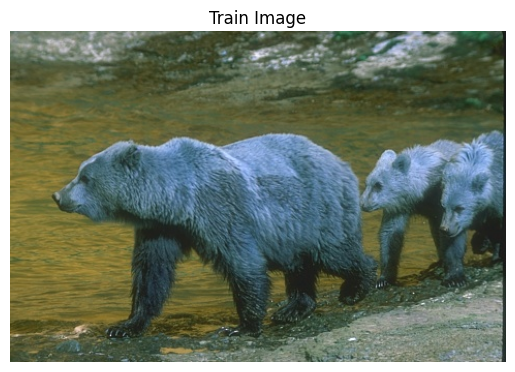

--


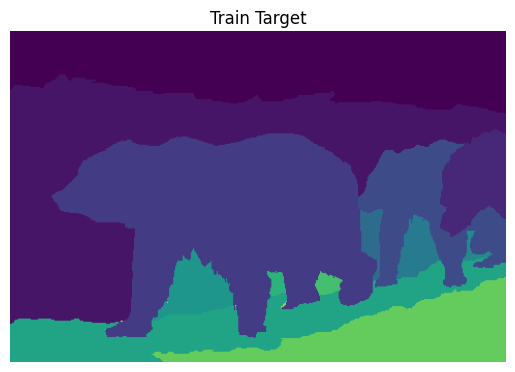

--


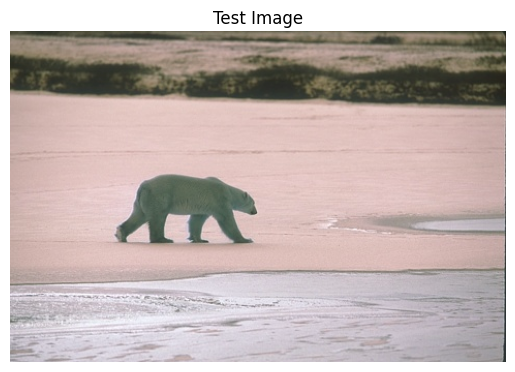

--


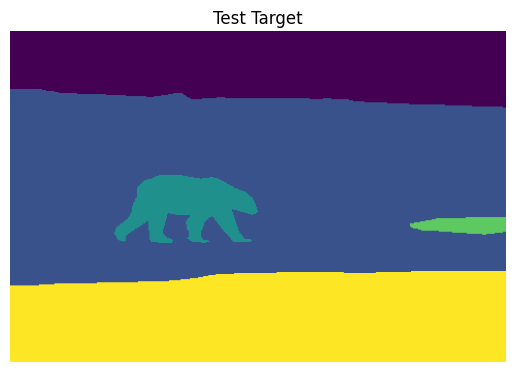

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def mostrar_img(img, titulo=""):

    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
        if img.shape[0] == 1:  # Grayscale
            img = img[0]
        else:
            img = np.transpose(img, (1, 2, 0))  # CxHxW → HxWxC

    # Garante que a imagem esteja entre 0 e 255 e como uint8
    if img.max() > 1.0:
        img = np.clip(img, 0, 255).astype(np.uint8)
    else:
        img = np.clip(img, 0.0, 1.0)

    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(titulo)
    plt.axis('off')
    plt.show()


mostrar_img(torch_2_cv(train_images[0]), "Train Image")
print("--")
tg = torch_2_cv(train_targets[0])
mostrar_img(tg * 255 / np.max(tg), "Train Target")
print("--")
mostrar_img(torch_2_cv(test_images[0]), "Test Image")
print("--")
tg = torch_2_cv(test_targets[0])
mostrar_img(tg * 255 / np.max(tg), "Test Target")


In [17]:
train_images = [x.reshape((1,x.size()[0],x.size()[1],x.size()[2])) for x in train_images]
test_images = [x.reshape((1,x.size()[0],x.size()[1],x.size()[2])) for x in test_images]
train_targets = [x.reshape((1,x.size()[0],x.size()[1],x.size()[2])) for x in train_targets]
test_targets = [x.reshape((1,x.size()[0],x.size()[1],x.size()[2])) for x in test_targets]

train_images = torch.cat(train_images)
test_images = torch.cat(test_images)
train_targets = torch.cat(train_targets)
test_targets = torch.cat(test_targets)

print(train_images.size())
print(test_images.size())
print(train_targets.size())
print(test_targets.size())


torch.Size([200, 3, 320, 480])
torch.Size([200, 3, 320, 480])
torch.Size([200, 1, 320, 480])
torch.Size([200, 1, 320, 480])


### Questão nº 02 (2 pts)

Compare resultado da U-net com e sem as conexões residuais na base de dados Berkeley.


In [15]:
# Implemente aqui!
import torch
import torchvision

class BlocoEncoderResidual(torch.nn.Module):
    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=3, padding=padding)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.relu2 = torch.nn.ReLU(inplace=True)
        self.pool = torch.nn.MaxPool2d(2)

        # Ajusta dimensões para a soma residual (se necessário)
        if num_canais_entrada != num_canais_saida or padding == 'valid':
            self.adjust = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=1)
        else:
            self.adjust = None

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        if self.adjust is not None:
            residual = self.adjust(residual)
            # Se padding='valid', tamanho espacial pode diminuir, ajustar aqui se quiser.
            # Para simplicidade, aqui assumimos padding='same' para usar residual direto.
        out += residual
        out = self.relu2(out)
        out = self.pool(out)
        return out

class BlocoDecoderResidual(torch.nn.Module):
    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        self.up = torch.nn.ConvTranspose2d(num_canais_entrada, num_canais_entrada // 2, kernel_size=2, stride=2)
        self.conv1 = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=3, padding=padding)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.relu2 = torch.nn.ReLU(inplace=True)

        # Ajuste para residual interno
        if num_canais_entrada != num_canais_saida or padding == 'valid':
            self.adjust = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=1)
        else:
            self.adjust = None

    def forward(self, x, skip_connection):
        x = self.up(x)
        skip_connection = torchvision.transforms.Resize((x.size(2), x.size(3)))(skip_connection)
        x = torch.cat([skip_connection, x], dim=1)  # concatena canais

        residual = x
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)

        if self.adjust is not None:
            residual = self.adjust(residual)
            # Ajustar tamanho espacial se necessário (assumindo padding same aqui)
        out += residual
        out = self.relu2(out)
        return out

class UNetResidual(torch.nn.Module):
    def __init__(self, n_channels, n_classes, padding='valid'):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.encoder1 = BlocoEncoderResidual(n_channels, 64, padding=padding)
        self.encoder2 = BlocoEncoderResidual(64, 128, padding=padding)
        self.encoder3 = BlocoEncoderResidual(128, 256, padding=padding)
        self.encoder4 = BlocoEncoderResidual(256, 512, padding=padding)

        self.base1 = torch.nn.Conv2d(512, 1024, kernel_size=3, padding=padding)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.base2 = torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=padding)
        self.relu2 = torch.nn.ReLU(inplace=True)

        self.decoder1 = BlocoDecoderResidual(1024, 512, padding=padding)
        self.decoder2 = BlocoDecoderResidual(512, 256, padding=padding)
        self.decoder3 = BlocoDecoderResidual(256, 128, padding=padding)
        self.decoder4 = BlocoDecoderResidual(128, 64, padding=padding)

        self.conv_final = torch.nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)

        x = self.base1(x4)
        x = self.relu1(x)
        x = self.base2(x)
        x = self.relu2(x)

        x = self.decoder1(x, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)

        x = self.conv_final(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Instancia modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetResidual(n_channels=3, n_classes=1, padding='same').to(device)

# Critério e otimizador
criterion = nn.BCEWithLogitsLoss()  # para segmentação binária com saída raw logits
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Dataset e DataLoader simples
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_images.to(device), train_targets.to(device))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, targets in train_loader:
        optimizer.zero_grad()

        outputs = model(imgs)

        # Se targets têm shape (batch,1,H,W), outputs idem
        loss = criterion(outputs, targets.float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")


Epoch 1/10 - Loss: 0.8545
Epoch 2/10 - Loss: 0.1218
Epoch 3/10 - Loss: 0.1198
Epoch 4/10 - Loss: 0.1191
Epoch 5/10 - Loss: 0.1191
Epoch 6/10 - Loss: 0.1191
Epoch 7/10 - Loss: 0.1184
Epoch 8/10 - Loss: 0.1181
Epoch 9/10 - Loss: 0.1190
Epoch 10/10 - Loss: 0.1185


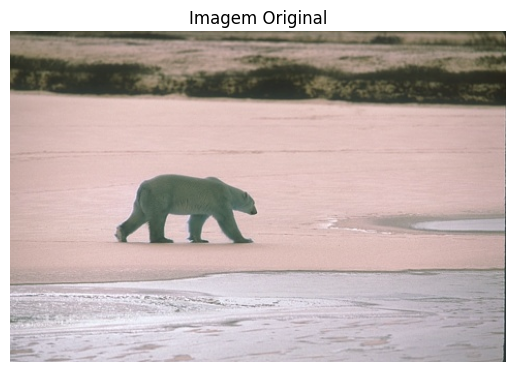

In [ ]:
def mostrar_img_rgb(tensor_img, titulo=""):
    img = tensor_img.cpu().detach().numpy()
    if img.max() <= 1.0:
        img = img * 255
    img = img.astype(np.uint8)
    if img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.title(titulo)
    plt.axis('off')
    plt.show()

mostrar_img_rgb(img.squeeze(), "Imagem Original")


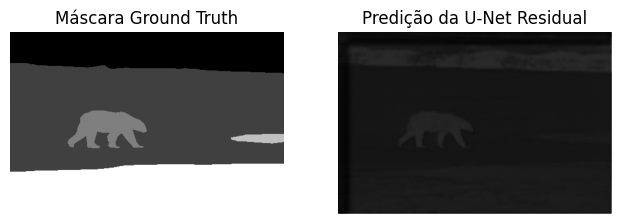

In [ ]:
import torch
import matplotlib.pyplot as plt

# Escolha uma imagem de teste
img = test_images[0].unsqueeze(0).to(device)
target = test_targets[0]

model.eval()  # coloca o modelo em modo avaliação
with torch.no_grad():
    output = model(img)  # saída logits, shape (1, n_classes, H, W)
    prob = torch.sigmoid(output)  # converte logits para probabilidade (0 a 1)

# Converta para numpy para exibir
prob_img = prob.squeeze().cpu().numpy()  # remove batch e canal extra, se n_classes=1

# Mostra a imagem original, máscara real e saída da rede
plt.figure(figsize=(12,4))

plt.subplot(1,3,2)
plt.title("Máscara Ground Truth")
plt.imshow(target.squeeze().cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Predição da U-Net Residual")
plt.imshow(prob_img, cmap='gray')
plt.axis('off')

plt.show()


### Questão nº 03 (1 pt)

Responda: É possível usar funções de ativação como a softmax em problemas de segmentação? Se sim, explique como. Se não, explique o motivo.

Sim, é possível usar a função de ativação softmax em problemas de segmentação. Na segmentação, o objetivo é classificar cada pixel da imagem em uma classe específica. Para isso, a saída da rede normalmente tem C canais, onde C é o número de classes.
A função softmax é aplicada pixel a pixel, transformando o vetor de logits dos canais em uma distribuição de probabilidade entre as classes para aquele pixel.

### Questão nº 04 (2 pt)

Crie uma arquitetura de rede totalmente convolucional onde não há perda de resolução em nenhuma camada convolucional. Não use a camada de deconvolução ou pooling, apenas as camadas de convolução com padding.

Treine-a na base de dados Berkeley e faça uma breve comparação com os resultados obtidos ao usar a U-net


In [ ]:
# Implemente aqui!
import torch

class RedeTotalmenteConvolucional(torch.nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()

        #  padding='same' para manter a resolução

        self.conv1 = torch.nn.Conv2d(n_channels, 64, kernel_size=3, padding=1)  # mantém tamanho
        self.relu1 = torch.nn.ReLU(inplace=True)

        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = torch.nn.ReLU(inplace=True)

        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = torch.nn.ReLU(inplace=True)

        self.conv4 = torch.nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.relu4 = torch.nn.ReLU(inplace=True)

        self.conv5 = torch.nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.relu5 = torch.nn.ReLU(inplace=True)

        self.conv_final = torch.nn.Conv2d(64, n_classes, kernel_size=1) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.relu5(x)

        x = self.conv_final(x)
        return x


In [18]:
model = RedeTotalmenteConvolucional(n_channels=3, n_classes=1).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_images.to(device), train_targets.to(device))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader.dataset):.4f}")


Epoch 1/10 - Loss: 0.1951
Epoch 2/10 - Loss: 0.1241
Epoch 3/10 - Loss: 0.1213
Epoch 4/10 - Loss: 0.1238
Epoch 5/10 - Loss: 0.1226
Epoch 6/10 - Loss: 0.1196
Epoch 7/10 - Loss: 0.1216
Epoch 8/10 - Loss: 0.1214
Epoch 9/10 - Loss: 0.1206
Epoch 10/10 - Loss: 0.1211


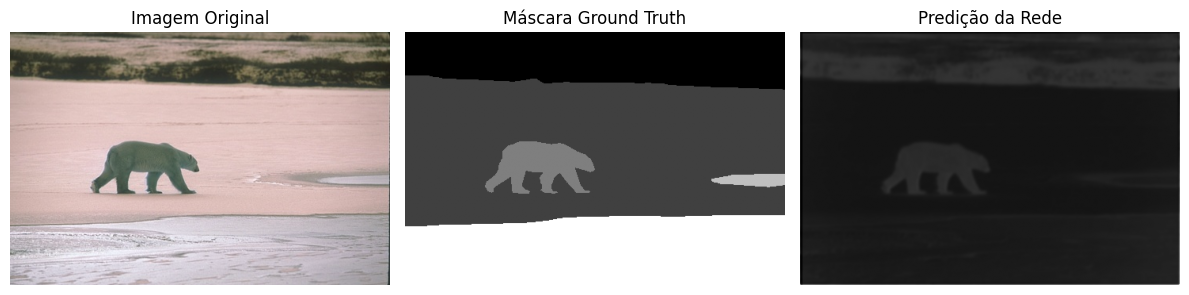

In [ ]:
import matplotlib.pyplot as plt
import torch

# Seleciona uma imagem de teste
img = test_images[0].unsqueeze(0).to(device)  # adiciona batch dimension
target = test_targets[0]  # ground truth para visualização

model.eval()  # modo de avaliação
with torch.no_grad():
    output = model(img)                # logits (saída bruta)
    prob = torch.sigmoid(output)      # converte logits em probabilidade (0-1)

# Remove dimensões extras para visualização
img_np = img.squeeze().cpu().numpy()
if img_np.shape[0] == 3:
    img_np = np.transpose(img_np, (1, 2, 0))  # CxHxW -> HxWxC

gt_np = target.squeeze().cpu().numpy()
pred_np = prob.squeeze().cpu().numpy()

# Plota os resultados
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Imagem Original")
plt.imshow((img_np * 255).astype(np.uint8))
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Máscara Ground Truth")
plt.imshow(gt_np, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Predição da Rede")
plt.imshow(pred_np, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


### Questão nº 05 (2 pts)

Vimos que, na U-net, pode ou não haver uso de padding. Para que a saída tenha tamanho igual à entrada, devemos usá-lo.

Faça um breve teste: Treine a U-net com padding e compare a saída dela com uma u-net treinada sem padding. A saída dessa segunda deve ser redimensionada para que ela volte a resolução original.

Ex: Na imagem da U-net, a entrada era 572x572 e a saída era 388x388. Use algum método resize para voltar a imagem de 388x388 para a resolução original.

Faça uma análise visual e compare os erros quadráticos médios das duas abordagens.

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import mean_squared_error

# 1. Instanciar os modelos
unet_res_same = UNetResidual(n_channels=3, n_classes=1, padding='same').to(device)
unet_res_valid = UNetResidual(n_channels=3, n_classes=1, padding='valid').to(device)

# 2. Otimizadores e função de perda
optimizer_res_same = torch.optim.Adam(unet_res_same.parameters(), lr=1e-3)
optimizer_res_valid = torch.optim.Adam(unet_res_valid.parameters(), lr=1e-3)
loss_fn = torch.nn.BCEWithLogitsLoss()

# 3. Dataset e DataLoader
train_dataset = TensorDataset(train_images.to(device), train_targets.to(device))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# 4. Função de treino com ajuste de tamanho
def treinar_modelo(model, optimizer, n_epochs=5):
    for epoch in range(1, n_epochs+1):
        model.train()
        total_loss = 0.0

        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x)                            # [B, C, H_out, W_out]
            
            # 1) Redimensiona 'out' para ter exatamente as mesmas H×W de 'y'
            out = F.interpolate(
                out,
                size=y.shape[2:],                     # pega (altura, largura) de y
                mode='bilinear',                      # ou 'nearest' se for segmentação binária
                align_corners=False
            )

            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch}/{n_epochs} — Loss média: {avg_loss:.4f}")
# 5. Treinar os modelos
print("🔁 Treinando U-Net Residual com padding='same'")
treinar_modelo(unet_res_same, optimizer_res_same, n_epochs=5)


🔁 Treinando U-Net Residual com padding='same'
Epoch 1/5 — Loss média: 0.5083
Epoch 2/5 — Loss média: 0.1207
Epoch 3/5 — Loss média: 0.1196
Epoch 4/5 — Loss média: 0.1195
Epoch 5/5 — Loss média: 0.1200


In [26]:
import torch
import torch.nn.functional as F

class BlocoEncoderResidual(torch.nn.Module):
    def __init__(self, in_channels, out_channels, padding='same'):
        super().__init__()
        pad = 1 if padding=='same' else 0
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=pad)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=pad)
        self.relu2 = torch.nn.ReLU(inplace=True)
        self.pool = torch.nn.MaxPool2d(2)
        self.adjust = None
        if in_channels != out_channels:
            self.adjust = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)

        if self.adjust:
            residual = self.adjust(residual)

        # Se dimensões diferentes, faz interpolação
        if residual.shape[2:] != out.shape[2:]:
            residual = F.interpolate(residual, size=out.shape[2:], mode='bilinear', align_corners=False)

        out = out + residual
        out = self.relu2(out)
        out = self.pool(out)
        return out

class BlocoDecoderResidual(torch.nn.Module):
    def __init__(self, in_channels, out_channels, padding='same'):
        super().__init__()
        pad = 1 if padding=='same' else 0
        mid_channels = in_channels // 2
        self.up = torch.nn.ConvTranspose2d(in_channels, mid_channels, kernel_size=2, stride=2)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=pad)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=pad)
        self.relu2 = torch.nn.ReLU(inplace=True)
        self.adjust = None
        if in_channels != out_channels:
            self.adjust = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x, skip):
        x = self.up(x)

        # Interpola skip para o mesmo H×W de x
        if skip.shape[2:] != x.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)

        x = torch.cat([skip, x], dim=1)
        residual = x

        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)

        if self.adjust:
            residual = self.adjust(residual)

        # Interpola residual para o mesmo H×W de out
        if residual.shape[2:] != out.shape[2:]:
            residual = F.interpolate(residual, size=out.shape[2:], mode='bilinear', align_corners=False)

        out = out + residual
        out = self.relu2(out)
        return out

class UNetResidual(torch.nn.Module):
    def __init__(self, n_channels, n_classes, padding='same'):
        super().__init__()
        self.enc1 = BlocoEncoderResidual(n_channels, 64, padding)
        self.enc2 = BlocoEncoderResidual(64, 128, padding)
        self.enc3 = BlocoEncoderResidual(128, 256, padding)
        self.enc4 = BlocoEncoderResidual(256, 512, padding)

        pad = 1 if padding=='same' else 0
        self.center = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, kernel_size=3, padding=pad),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=pad),
            torch.nn.ReLU(inplace=True)
        )

        self.dec1 = BlocoDecoderResidual(1024, 512, padding)
        self.dec2 = BlocoDecoderResidual(512, 256, padding)
        self.dec3 = BlocoDecoderResidual(256, 128, padding)
        self.dec4 = BlocoDecoderResidual(128, 64, padding)
        self.conv_final = torch.nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)

        x_center = self.center(x4)

        x = self.dec1(x_center, x4)
        x = self.dec2(x, x3)
        x = self.dec3(x, x2)
        x = self.dec4(x, x1)

        out = self.conv_final(x)
        return out


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

def treinar_modelo(model, optimizer, train_loader, loss_fn, n_epochs=5, device='cuda'):
    model.to(device)
    for epoch in range(1, n_epochs+1):
        model.train()
        total_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device).float()

            optimizer.zero_grad()
            out = model(x)  # [B, C, H_out, W_out]

            # Garante que out e y tenham o mesmo H×W
            if out.shape[2:] != y.shape[2:]:
                out = F.interpolate(
                    out,
                    size=y.shape[2:],       # (altura, largura) de y
                    mode='bilinear',
                    align_corners=False
                )

            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch}/{n_epochs} — Loss média: {avg_loss:.4f}")

# --- Uso ---

# 1) Instâncias
unet_res_same  = UNetResidual(n_channels=3, n_classes=1, padding='same')
unet_res_valid = UNetResidual(n_channels=3, n_classes=1, padding='valid')

# 2) Optimizadores e loss
opt_same  = torch.optim.Adam(unet_res_same.parameters(),  lr=1e-3)
opt_valid = torch.optim.Adam(unet_res_valid.parameters(), lr=1e-3)
loss_fn   = torch.nn.BCEWithLogitsLoss()

# 3) DataLoader
train_dataset = TensorDataset(train_images, train_targets)
train_loader  = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

# 4) Treinos

print("\n🔁 Treinando U-Net Residual com padding='valid'")
treinar_modelo(unet_res_valid, opt_valid, train_loader, loss_fn, n_epochs=5, device=device)



🔁 Treinando U-Net Residual com padding='valid'
Epoch 1/5 — Loss média: 0.3562
Epoch 2/5 — Loss média: 0.1210
Epoch 3/5 — Loss média: 0.1190
Epoch 4/5 — Loss média: 0.1209
Epoch 5/5 — Loss média: 0.1186
